In [1]:
pip install DeepXDE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 5.2 MB/s eta 0:00:00


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.110213 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.590055 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [5.86e-02, 9.15e-01, 3.44e-15, 1.53e-17, 2.67e-14, 1.47e-16, 5.03e-02, 4.00e-01]    [5.86e-02, 9.15e-01, 3.44e-15, 1.53e-17, 2.67e-14, 1.47e-16, 5.03e-02, 4.00e-01]    []  
1000      [4.22e-05, 1.09e-05, 1.42e-15, 1.48e-17, 1.50e-15, 1.99e-17, 1.45e-02, 1.43e-02]    [4.22e-05, 1.09e-05, 1.42e-15, 1.48e-17, 1.50e-15, 1.99e-17, 1.45e-02, 1.43e-02]    []  
2000      [7.45e-06, 7.49e-06, 7.44e-16, 1.45e-17, 1.36e-15, 1.45e-17, 1.42e-02, 1.42e-02]    [7.45e-06, 7.49e-06, 7.44e-16, 1.45e-17, 1.36e-15, 1.45e-17, 1.42e-02, 1.42e-02]    []  
3000      [7.77e-06, 9.17e-06, 1.91e-15, 2.43e-17, 1.07e-15, 1.48e-17, 1.41e-02, 1.41e-02]    [7.77e-06, 9.17e-06, 1.91e-15, 2.43e-17, 1.07e-15, 1.48e-17, 1.41e-02, 1.41e-02]    []  
4000      [6.52e-06, 6.64e-06, 1

x    t    pred_u    pred_v    pred_h    true_u    true_v  \
0     -25.000000  0.0 -0.003017 -0.001178  0.003239  0.000119  0.000016   
1     -24.803922  0.0 -0.002664 -0.000858  0.002798  0.000122  0.000042   
2     -24.607843  0.0 -0.002199 -0.000532  0.002262  0.000119  0.000069   
3     -24.411765  0.0 -0.001674 -0.000225  0.001689  0.000111  0.000097   
4     -24.215686  0.0 -0.001142  0.000035  0.001142  0.000096  0.000125   
...          ...  ...       ...       ...       ...       ...       ...   
51451  24.215686  1.0 -0.003263  0.006404  0.007187 -0.000141 -0.000614   
51452  24.411765  1.0 -0.001999  0.007330  0.007597 -0.000018 -0.000588   
51453  24.607843  1.0 -0.000683  0.007722  0.007752  0.000091 -0.000543   
51454  24.803922  1.0  0.000523  0.007518  0.007536  0.000182 -0.000481   
51455  25.000000  1.0  0.001483  0.006708  0.006870  0.000254 -0.000407   

         true_h  
0      0.000120  
1      0.000129  
2      0.000138  
3      0.000147  
4      0.000158  
...         ...  
51451  0.000630  
51452  0.000589  
51453  0.000550  
51454  0.000514  
51455  0.000480  

[51456 rows x 8 columns]

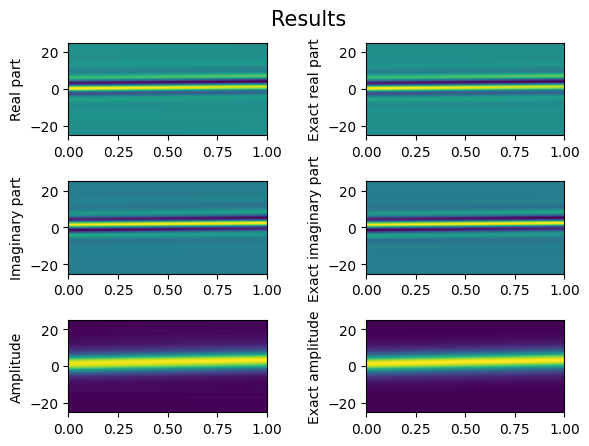

In [2]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from IPython.display import display
import tensorflow as tf


x_lower = -25
x_upper = 25
t_lower = 0
t_upper = 1

α = 0
β = 0

α_0 = 0
k = 1
ω = 0.88
x_0 = 0
θ_0 = 0
μ = 4 * (k ** 2 - ω)

x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = -v_t + u_xx + u * (u ** 2 + v ** 2) * (1 - α * (u ** 2 + v ** 2) + β * (u ** 2 + v ** 2) ** 2)
    f_v = u_t + v_xx + v * (u ** 2 + v ** 2) * (1 - α * (u ** 2 + v ** 2) + β * (u ** 2 + v ** 2) ** 2)

    return [f_u, f_v]


bc_u_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)


def init_cond_u(x):
    return np.cos(k * x[:, 0:1] + θ_0) * np.sqrt(μ * np.exp((x[:, 0:1] - x_0) * np.sqrt(μ)) / (
                ((1 / 2) * np.exp((x[:, 0:1] - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
            2 * (x[:, 0:1] - x_0) * np.sqrt(μ))))


def init_cond_v(x):
    return np.sin(k * x[:, 0:1] + θ_0) * np.sqrt(μ * np.exp((x[:, 0:1] - x_0) * np.sqrt(μ)) / (
                ((1 / 2) * np.exp((x[:, 0:1] - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
            2 * (x[:, 0:1] - x_0) * np.sqrt(μ))))


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

# предобработка входа


def input_transform(input_data):
    x1 = tf.cos(2 * np.pi * (input_data[:, 0:1] - x_lower) / (x_upper - x_lower))
    x2 = tf.sin(2 * np.pi * (input_data[:, 0:1] - x_lower) / (x_upper - x_lower))
    t = input_data[:, 1:2]

    return tf.concat([x1, x2, t], axis=1)


net = dde.nn.FNN([2] + [32] * 2 + [2], "sin", "Glorot normal")

net.apply_feature_transform(input_transform)

model = dde.Model(data, net)

model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=10000, display_every=1000)

prediction = model.predict(X_star)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

q = np.sqrt(u ** 2 + v ** 2)


def u_exact(x, t):
    return np.cos(k * x - ω * t + θ_0) * np.sqrt(μ * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) / (
                ((1 / 2) * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
            2 * (x - 2 * k * t - x_0) * np.sqrt(μ))))


def v_exact(x, t):
    return np.sin(k * x - ω * t + θ_0) * np.sqrt(μ * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) / (
            ((1 / 2) * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
        2 * (x - 2 * k * t - x_0) * np.sqrt(μ))))


def q_exact(x, t):
    return np.sqrt(μ * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) / (
            ((1 / 2) * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
        2 * (x - 2 * k * t - x_0) * np.sqrt(μ))))


data_ = {'x': X.flatten(), 't': T.flatten(), 'pred_u': u.flatten(), 'pred_v': v.flatten(), 'pred_h': q.flatten(),
        'true_u': u_exact(X, T).flatten(), 'true_v': v_exact(X, T).flatten(), 'true_h': q_exact(X, T).flatten()
         }

df = pd.DataFrame(data_)
df.to_orc('my_data_pred2.orc')
display(df)

fig, ax = plt.subplots(3, 2)

plt.suptitle("Results", fontsize=15, x=0.5, y=0.95)

ax[0, 0].set_ylabel("Real part")
ax[0, 0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1, 0].set_ylabel("Imaginary part")
ax[1, 0].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2, 0].set_ylabel("Amplitude")
ax[2, 0].imshow(
    q.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

ax[0, 1].set_ylabel("Exact real part")
ax[0, 1].imshow(
    u_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1, 1].set_ylabel("Exact imaginary part")
ax[1, 1].imshow(
    v_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2, 1].set_ylabel("Exact amplitude")
ax[2, 1].imshow(
    q_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()